# Section II.

## Dask image parallelization dev notebook

Created on: Monday March 28th, 2022  
Created by: Jacob Alexander Rose  

In [1]:
# %%bash

# !export OMP_NUM_THREADS=1
# export MKL_NUM_THREADS=1
# export OPENBLAS_NUM_THREADS=1
# echo '${OMP_NUM_THREADS}'


# import dask

# @dask.delayed
# def load(filename):
#     ...

# @dask.delayed
# def process(data):
#     ...

# @dask.delayed
# def save(data):
#     ...


# def f(filenames):
#     results = []
#     for filename in filenames:
#         data = load(filename)
#         data = process(data)
#         result = save(data)

#     return results

# dask.compute(f(filenames))

In [2]:
# source: https://examples.dask.org/machine-learning/torch-prediction.html
from typing import *

import glob
import toolz
import dask
import dask.array as da
import torch
from torchvision import transforms
from PIL import Image
import pandas as pd
pd.set_option("display.max_colwidth", 150)
import numpy as np
from imutils.ml.data.datamodule import Herbarium2022DataModule, Herbarium2022Dataset

Importing imutils


In [3]:
# @dask.delayed
# def transform(img):
#     trn = transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
#             transforms.ToTensor(),
#             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
#     return trn(img)

In [6]:
import os
from pathlib import Path
import dask
import dask.dataframe as dd
#####################################################


@dask.delayed
def load(path: str,
         fs=__builtins__):
    with fs.open(path, 'rb') as f:
        img = Image.open(f).convert("RGB")
        return img

@dask.delayed
def process(img: Image.Image,
            size: Tuple[int]):
    img = img.resize(size=size,
                     resample=Image.BICUBIC)
    return img

@dask.delayed
def save(img: Image.Image,
         target_path: str,
         fs=__builtins__):
    with fs.open(target_path, 'wb') as f:
        img = Image.save(f, format="jpeg")
    return os.path.isfile(target_path)



def run(data_chunk: pd.DataFrame):
    results = []
    for filename in filenames:
        data = load(filename)
        data = process(data)
        result = save(data)

    return results

# dask.compute(f(filenames))

from rich import print as pp
from dataclasses import dataclass, field

@dataclass
class Config:
    source_root_dir: Path = Path('/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize')
    target_root_dir_template: Path = Path('/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize')
    target_resolution: int = 512
    target_root_dir: str = field(init=False)
    
    def __post_init__(self):
        self.target_root_dir = Path(f"{str(self.target_root_dir_template)}-{self.target_resolution}")
        os.makedirs(self.target_root_dir, exist_ok=True)
        
    def get_target_path(self, source_path: Path) -> Path:
        """
        Finds the source path's location relative to the source root, and returns a new path at the same location relative to the target root.
        
        - source and target root dirs are specified at instantiation of config, must update instance attributes in order to chaange this method.
        """
        return str(self.target_root_dir / Path(source_path).relative_to(self.source_root_dir))
    
    def process_full_dataframe(self, data_df: pd.DataFrame) -> pd.DataFrame:
        """
        Prepare dataframe for large-scale image file processing.
        
        Creates a `target_path` column in data_df and fills it with values produced by self.get_target_path, then renames is as `path` while renaming the original colmn `path` to be `source_path`.
        
        """
        data_df = data_df.assign(target_path = data_df.path.apply(self.get_target_path, meta=("target_path", "string")))
        data_df = data_df.rename(columns={"path":"source_path",
                                          "target_path":"path"})
        data_df = data_df.sort_index()
        
        return data_df
    
    
    def read_dask_dataframe_from_csv(self,
                                    csv_path: str,
                                    columns: List[str],
                                    col_dtypes: Dict[str, Any]) -> dd.DataFrame:
        
        data_df = dd.read_csv(csv_path, usecols=["Unnamed: 0", *columns], dtype=col_dtypes
                              ).rename(columns={"Unnamed: 0":"idx"})
        data_df = data_df.set_index("idx")
        data_df = data_df.repartition(16)
        
        return data_df
    
    
    
cfg = Config()
pp(cfg)


catalog_dir = "/media/data/jacob/GitHub/image-utils/imutils/big/data"

train_csv_path = Path(catalog_dir, "train_metadata.csv")
test_csv_path = Path(catalog_dir, "test_metadata.csv")

train_columns = ['path', 'image_id',
           'category_id', 'genus_id', 'scientificName', 
           'Species', 'institution_id',
           'family', 'genus', 'species', 
           'file_name', 'collectionCode']

train_col_dtypes = {'path':"string",
                    'image_id':"string",
                    'category_id': "category",
                    'genus_id': "category",
                    'scientificName': "category",
                    'Species': "category",
                    'institution_id': "category",
                    'family': "category",
                    'genus': "category",
                    'species': "category",
                    'file_name': "string",
                    'collectionCode': "category"}

test_columns = ['path', 'image_id', 'file_name']
test_col_dtypes = {'path':"string",
                    'image_id':"string",
                    'file_name': "string"}




train_df = cfg.read_dask_dataframe_from_csv(csv_path=train_csv_path,
                                 columns=train_columns,
                                 col_dtypes=train_col_dtypes)

test_df = cfg.read_dask_dataframe_from_csv(csv_path=test_csv_path,
                                 columns=test_columns,
                                 col_dtypes=test_col_dtypes)

Config(
    source_root_dir=PosixPath('/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-
2022-fgvc9_resize'),
    target_root_dir_template=PosixPath('/media/data_cifs/projects/prj_fossils/data/raw_data/h
erbarium-2022-fgvc9_resize'),
    target_resolution=512,
    target_root_dir=PosixPath('/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-
2022-fgvc9_resize-512')
)

In [8]:
train_df.head()

,genus_id,institution_id,category_id,image_id,file_name,scientificName,family,genus,species,collectionCode,Species,path
idx,,,,,,,,,,,,
0,1,0,0,00000__001,000/00/00000__001.jpg,Abies amabilis (Douglas ex Loudon) J.Forbes,Pinaceae,Abies,amabilis,A,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/000/00/00000__001.jpg
1,1,0,0,00000__002,000/00/00000__002.jpg,Abies amabilis (Douglas ex Loudon) J.Forbes,Pinaceae,Abies,amabilis,A,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/000/00/00000__002.jpg
2,1,0,0,00000__003,000/00/00000__003.jpg,Abies amabilis (Douglas ex Loudon) J.Forbes,Pinaceae,Abies,amabilis,A,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/000/00/00000__003.jpg
3,1,0,0,00000__004,000/00/00000__004.jpg,Abies amabilis (Douglas ex Loudon) J.Forbes,Pinaceae,Abies,amabilis,A,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/000/00/00000__004.jpg
4,1,0,0,00000__005,000/00/00000__005.jpg,Abies amabilis (Douglas ex Loudon) J.Forbes,Pinaceae,Abies,amabilis,A,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/000/00/00000__005.jpg


In [7]:
test_df.head()

,image_id,file_name,path
idx,,,
0,0,000/test-000000.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/test_images/000/test-000000.jpg
1,1,000/test-000001.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/test_images/000/test-000001.jpg
2,2,000/test-000002.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/test_images/000/test-000002.jpg
3,3,000/test-000003.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/test_images/000/test-000003.jpg
4,4,000/test-000004.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/test_images/000/test-000004.jpg


In [22]:
# train_df = dd.read_csv(train_csv_path, usecols=["Unnamed: 0", *train_columns], dtype=train_col_dtypes
#                       ).rename(columns={"Unnamed: 0":"idx"})
# train_df = train_df.set_index("idx")
# train_df = train_df.repartition(16)
# train_df.head()


# data_df = data_df.assign(target_path = data_df.path.apply(cfg.get_target_path, meta=("target_path", "string")))
# data_df = data_df.rename(columns={"path":"source_path",
#                                   "target_path":"path"})
# data_df = data_df.sort_index()

In [6]:
seed = 85
random_state = np.random.RandomState(seed=seed)
# test_df = dd.read_csv(train_csv_path, index=0)
# train_df = pd.read_csv(train_csv_path, index_col=0, usecols=train_columns, dtype=train_col_dtypes)
# train_df.describe(include='all')

In [34]:
test_df = dd.read_csv(test_csv_path, usecols=["Unnamed: 0", *test_columns], dtype=test_col_dtypes
                      ).rename(columns={"Unnamed: 0":"idx"})
test_df = test_df.set_index("idx")
test_df = test_df.repartition(16)
test_df.head()

,image_id,file_name,path
idx,,,
0,0,000/test-000000.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/test_images/000/test-000000.jpg
1,1,000/test-000001.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/test_images/000/test-000001.jpg
2,2,000/test-000002.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/test_images/000/test-000002.jpg
3,3,000/test-000003.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/test_images/000/test-000003.jpg
4,4,000/test-000004.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/test_images/000/test-000004.jpg


In [20]:
%%time

train_df = dd.read_csv(train_csv_path, usecols=["Unnamed: 0", *train_columns], dtype=train_col_dtypes
                      ).rename(columns={"Unnamed: 0":"idx"})
                              # ).set_index("idx")
train_df = train_df.set_index("idx")
train_df = train_df.repartition(16)
train_df.head()

CPU times: user 10.5 s, sys: 1.57 s, total: 12.1 s
Wall time: 14.2 s


,genus_id,institution_id,category_id,image_id,scientificName,Species,path
idx,,,,,,,
0,1,0,0,00000__001,Abies amabilis (Douglas ex Loudon) J.Forbes,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/000/00/00000__001.jpg
1,1,0,0,00000__002,Abies amabilis (Douglas ex Loudon) J.Forbes,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/000/00/00000__002.jpg
2,1,0,0,00000__003,Abies amabilis (Douglas ex Loudon) J.Forbes,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/000/00/00000__003.jpg
3,1,0,0,00000__004,Abies amabilis (Douglas ex Loudon) J.Forbes,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/000/00/00000__004.jpg
4,1,0,0,00000__005,Abies amabilis (Douglas ex Loudon) J.Forbes,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/000/00/00000__005.jpg


#### Take a small fraction of dataset for testing

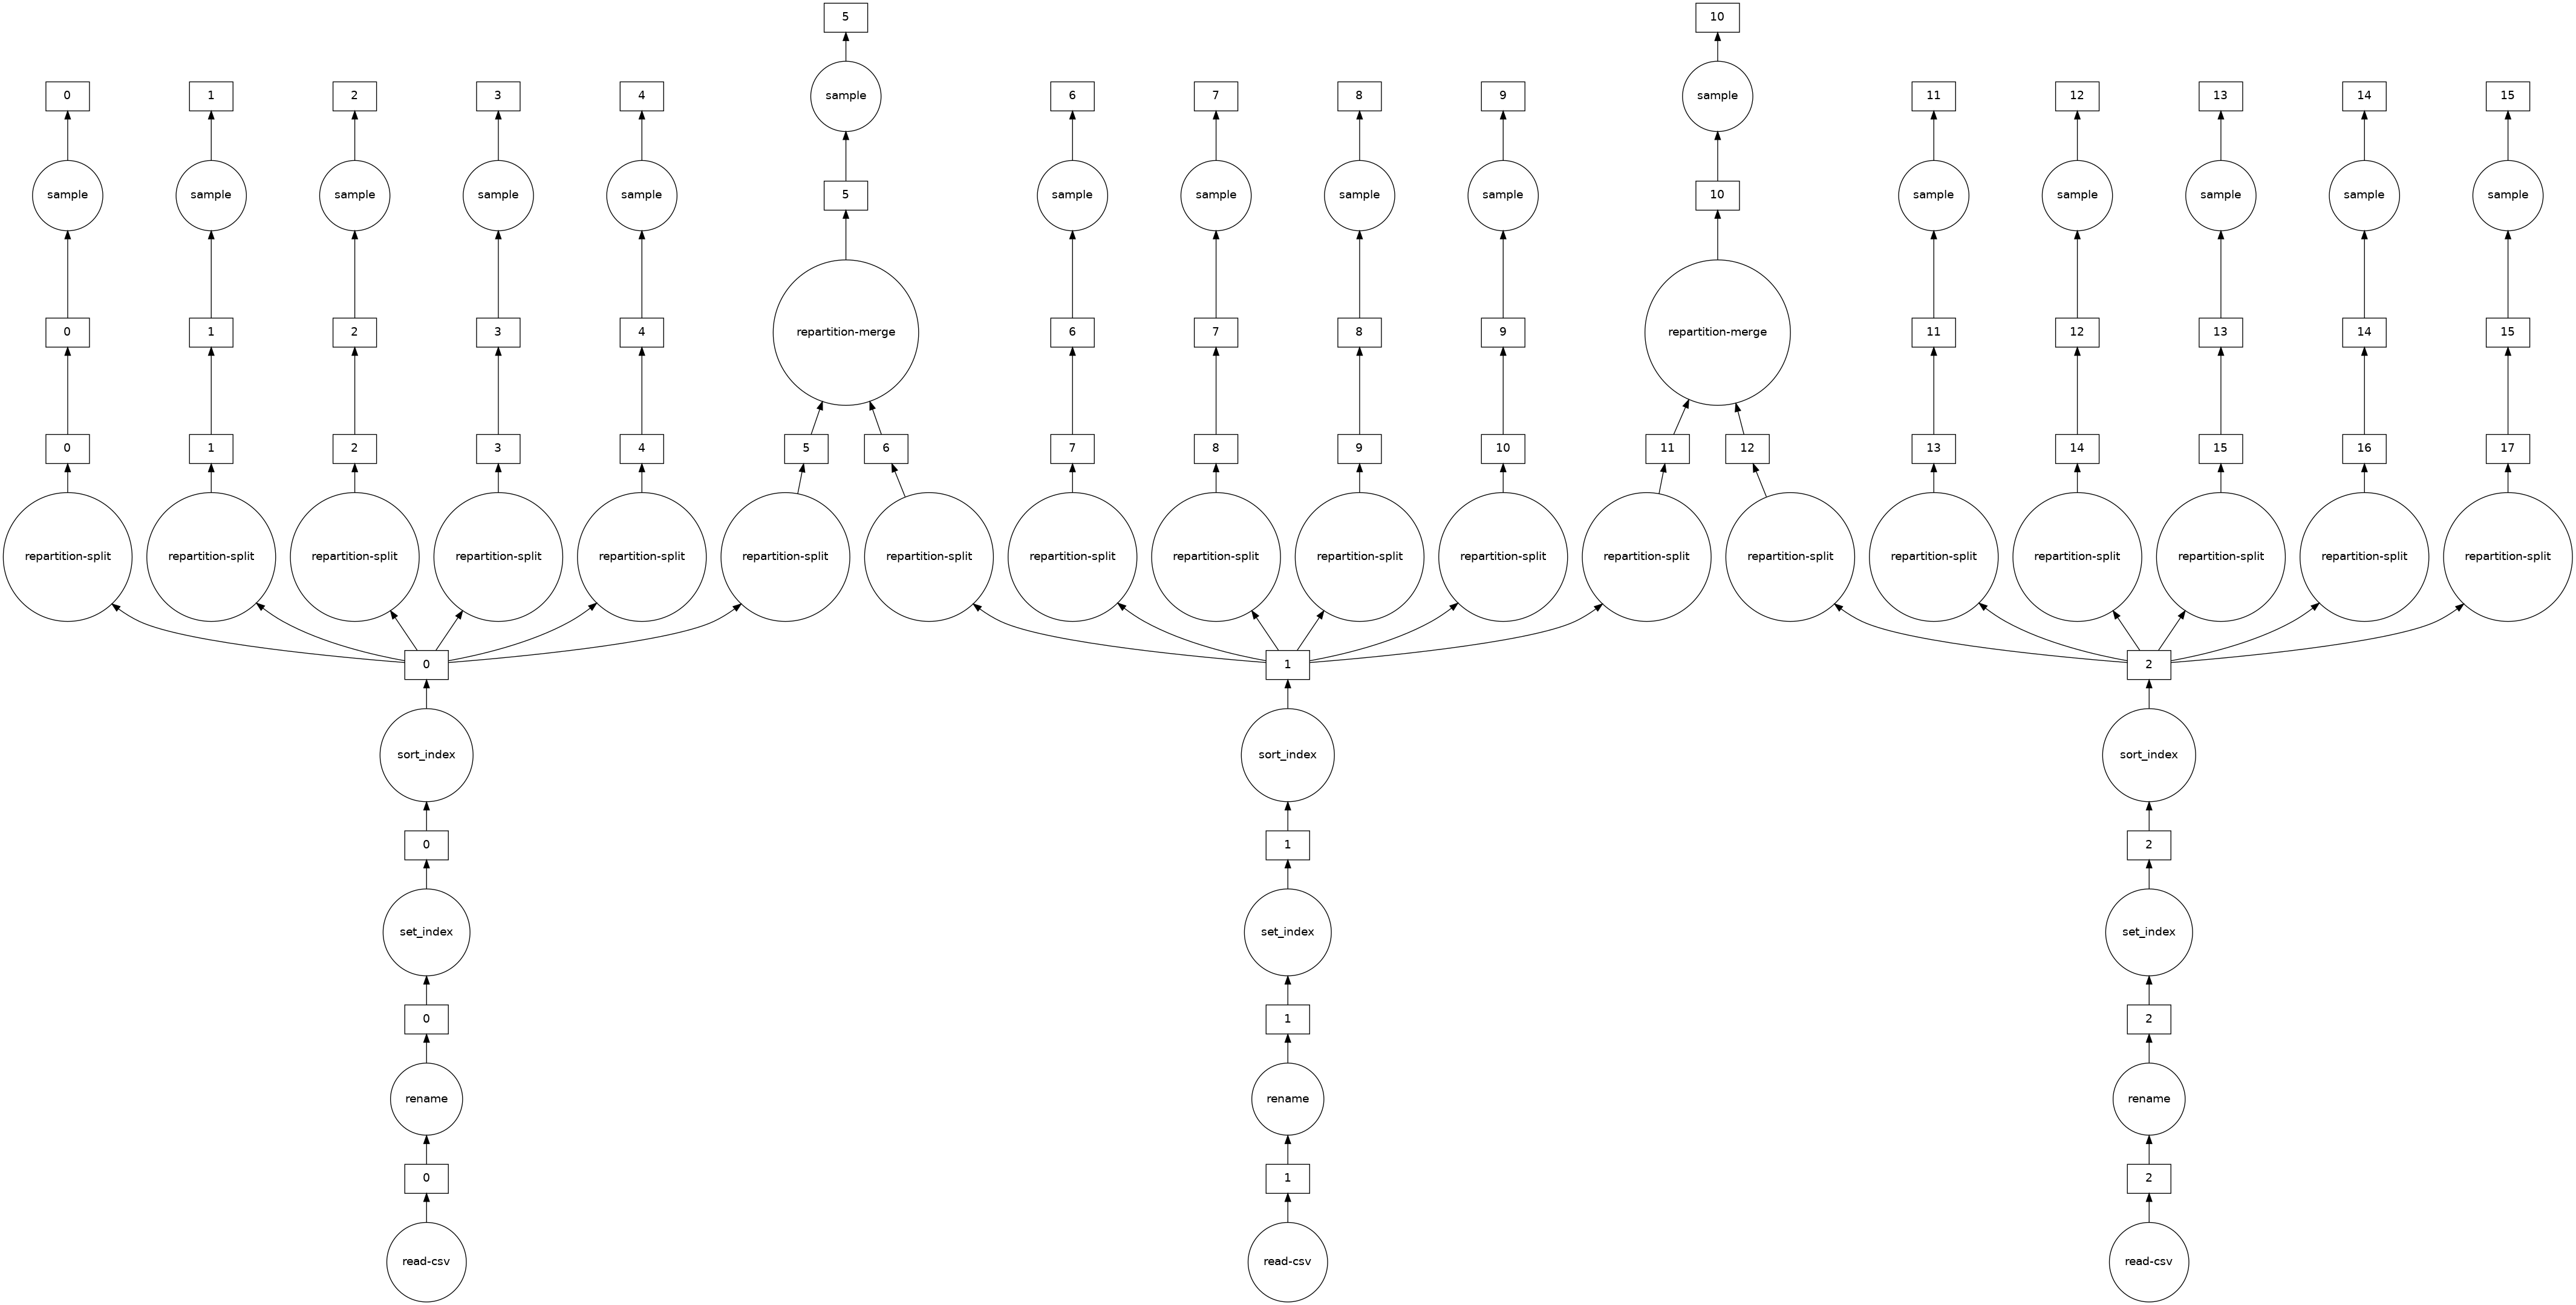

In [21]:
data_df = train_df.sample(frac=0.001,
                         replace=False,
                         random_state=random_state)


data_df.visualize()

In [42]:
for batch in data_df.itertuples():
    break
print(type(batch))

print(dir(batch))

batch.scientificName

batch.category_id

from IPython.display import display

display(batch)

In [43]:
!ls -alh '/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize'

total 659M
drwxrwxrwx 2 cis-storage cis-storage 2.0K Feb 18 17:14 .
drwxrwxrwx 2 cis-storage cis-storage 9.5K Mar 28 14:57 ..
drwxrwxrwx 2 cis-storage cis-storage 112K Feb 18 17:13 test_images
-rwxrwxrwx 1 cis-storage cis-storage  23M Feb 18 17:14 test_metadata.json
drwxrwxrwx 2 cis-storage cis-storage  78K Feb 18 16:41 train_images
-rwxrwxrwx 1 cis-storage cis-storage 637M Feb 18 17:14 train_metadata.json


In [24]:
df = data_df.compute()
df

,genus_id,institution_id,category_id,image_id,scientificName,Species,source_path,path
idx,,,,,,,,
22229,75,21,417,00417__002,Allium haematochiton S.Watson,Allium haematochiton,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/004/17/00417__002.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/train_images/004/17/00417__002.jpg
49039,174,36,957,00957__016,Aralia bicrenata Wooton & Standl.,Aralia bicrenata,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/009/57/00957__016.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/train_images/009/57/00957__016.jpg
49581,176,36,966,00966__028,Araujia odorata (Hook. & Arn.) Fontella & Goyder,Araujia odorata,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/009/66/00966__028.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/train_images/009/66/00966__028.jpg
47837,169,13,931,00931__094,Aquilegia elegantula Greene,Aquilegia elegantula,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/009/31/00931__094.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/train_images/009/31/00931__094.jpg
2959,7,38,52,00052__068,Acalypha chamaedrifolia (Lam.) Müll.Arg.,Acalypha chamaedrifolia,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/000/52/00052__068.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/train_images/000/52/00052__068.jpg
...,...,...,...,...,...,...,...,...
801592,2443,36,14786,14786__057,Trifolium variegatum Nutt.,Trifolium variegatum,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/147/86/14786__057.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/train_images/147/86/14786__057.jpg
798461,2440,53,14730,14730__080,Tridens flavus (L.) Hitchc.,Tridens flavus,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/147/30/14730__080.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/train_images/147/30/14730__080.jpg
818380,2507,52,15091,15091__063,Verbena simplex Lehm.,Verbena simplex,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/150/91/15091__063.jpg,/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize-512/train_images/150/91/15091__063.jpg


In [80]:

data_df.head(2).path.apply(lambda x: Path(x).parent.parent.parent.parent)

df = data_df.loc[0,:].persist()
df.persist()

In [3]:
topk = 2
ckpt_dir = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-28/09-32-27/ckpts/"

# ckpt_paths = [os.path.join(ckpt_dir, file_path) for file_path in sorted(os.listdir(ckpt_dir), reverse=True)][:2]
# pp(ckpt_paths)

ckpt_path = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-28/09-32-27/ckpts/epoch=10-val_loss=1.901-val_macro_F1=0.567/model_weights.ckpt"


# jrose/herbarium2022/2up1al9o

import os
import wandb


artifact = wandb.Artifact("model-weights", "checkpoints")
# Add Files and Assets to the artifact using 
# `.add`, `.add_file`, `.add_dir`, and `.add_reference`
artifact.add_file(ckpt_path)
artifact.save()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [1]:
os.environ["WANDB_PROJECT"]="herbarium2022"
!set | grep WANDB    


api = wandb.Api()

# run = api.run(overrides=dict(entity="jrose", project="herbarium2022", run="2up1al9o"))
run = api.run("herbarium2022/2up1al9o")

print(run)

run.upload_file(ckpt_path)
# for path in ckpt_paths:
#     print(f"Uploading file to wandb: {path}")
#     run.upload_file(path)
# run = wandb.init(project=PROJECT_NAME, resume=True)
run.finish

BASH_EXECUTION_STRING='set | grep WANDB'
WANDB_API_KEY=4da22f6127e7f77527340ffede80688f6e9fb597
WANDB_CACHE_DIR=/media/data/jacob/wandb_cache
WANDB_ENTITY=jrose
WANDB_PROJECT=herbarium2022


CommError: Could not find run <Run jrose/2up1al9o/2up1al9o (not found)>

In [3]:
# Herbarium2022DataModule,
catalog_dir = "/media/data/jacob/GitHub/image-utils/imutils/big/data"
data = Herbarium2022Dataset(catalog_dir=catalog_dir, subset="train", transform=transform)

# Download from wandb the best resnext50_4x30d or w/e from Experiment #18 2022-03-28 

In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('jrose/herbarium2022/model-weights:v8', type='checkpoints')
artifact_dir = artifact.download()

## etc

In [62]:
data_df.loc[:5,:]

%%time

demo = data_df.loc[:10,:].path.apply(cfg.get_target_path, meta=("target_path", "string"))
demo

# demo.compute()

demo = demo.persist()
demo

demo.shape[0].compute()

dir(demo)


data_df = data_df.assign(target_path = data_df.path.apply(cfg.get_target_path, meta=("target_path", "string")))
data_df.head(10)

In [52]:
# data_df = data_df.persist()
print(data_df.shape[0].compute())

836


In [54]:
# data_df = data_df.persist()
print(train_df.shape[0].compute())

839772


In [55]:
839772/836

1004.5119617224881

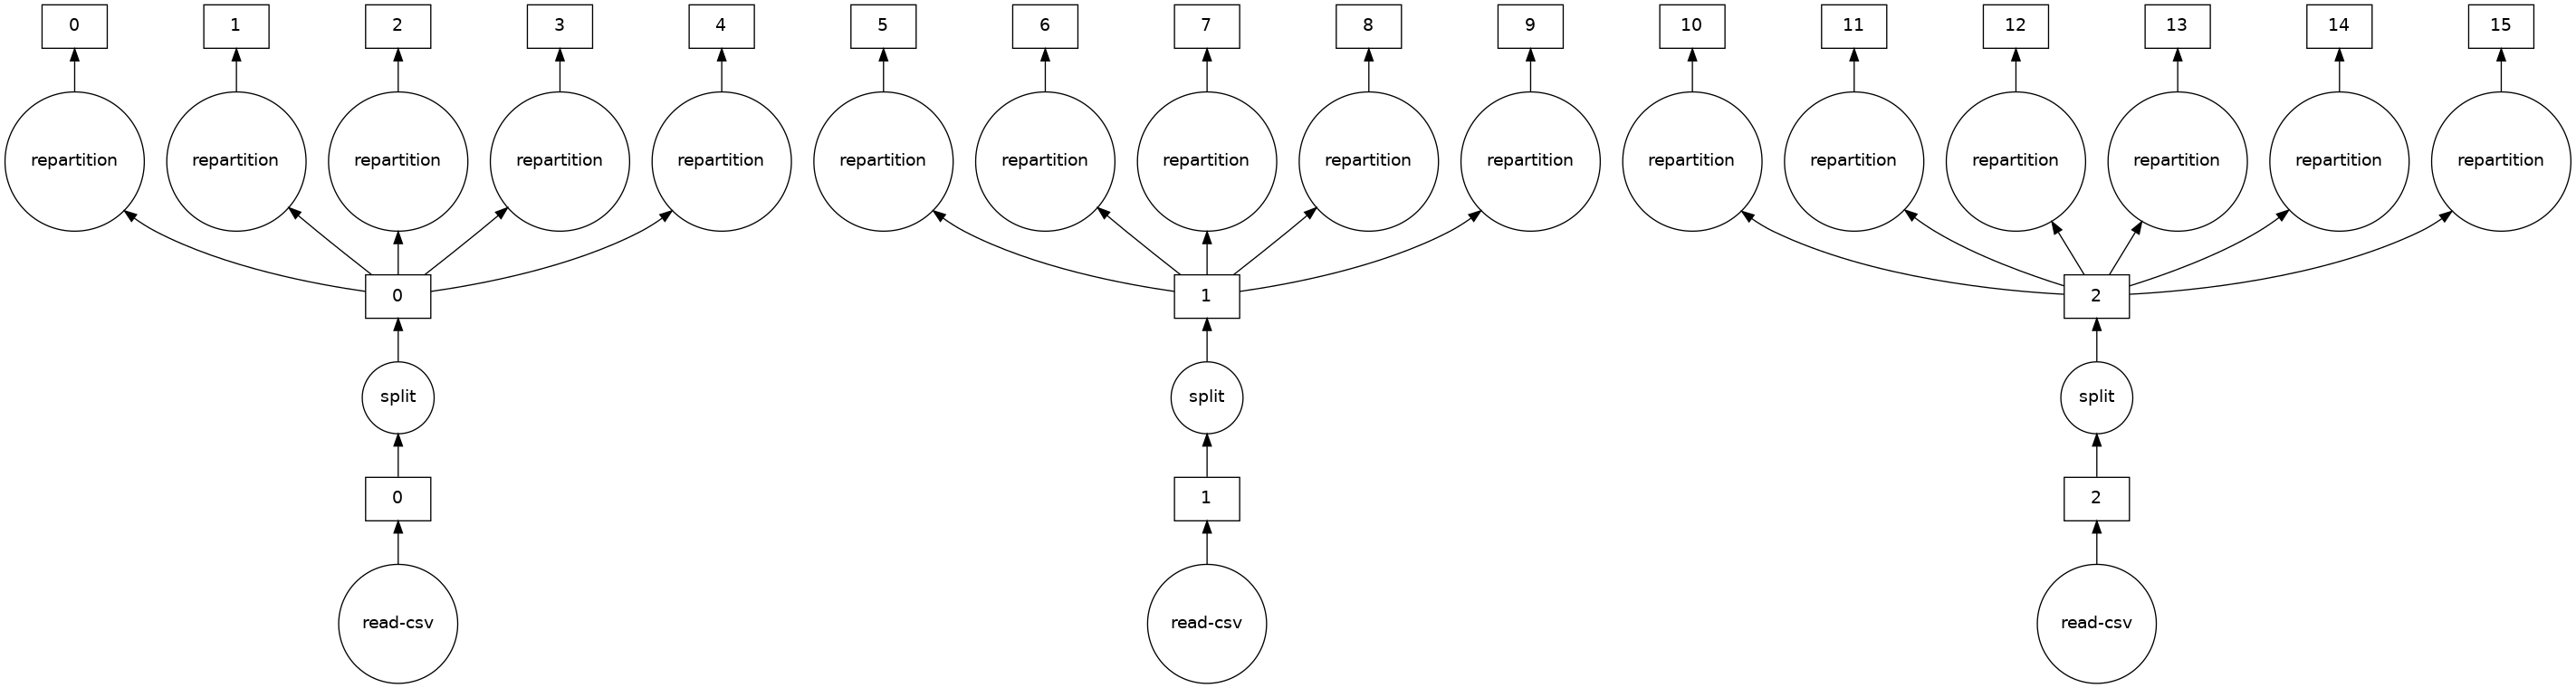

In [18]:
train_df.visualize()

In [25]:
def partition_info(data):
    print(f"type(data): {type(data)}")
    print(f"data.shape: {data.shape}")

In [26]:
result = train_df.map_partitions(partition_info)

# train_ddf = train_df.to_delayed()

type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (2, 7)


In [27]:
result.compute()

type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (56352, 7)
type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (56352, 7)
type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (56352, 7)
type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (56352, 7)
type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (56353, 7)
type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (46481, 7)
type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (46482, 7)
type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (46482, 7)
type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (46481, 7)
type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (46482, 7)
type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (46482, 7)
type(data): <class 'pandas.core.frame.DataFrame'>type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (55824, 7)
type(data): <class 'pandas.core.frame.DataFrame'>
data.shape: (55824, 7)
ty

0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
dtype: object

In [35]:
train_ddf

[Delayed(('read-csv-99176002aed2fff347a06449c1d63598', 0)),
 Delayed(('read-csv-99176002aed2fff347a06449c1d63598', 1)),
 Delayed(('read-csv-99176002aed2fff347a06449c1d63598', 2))]

In [28]:
%time train_df.head()

CPU times: user 1.58 s, sys: 240 ms, total: 1.82 s
Wall time: 1.95 s


,genus_id,institution_id,category_id,image_id,scientificName,Species,path
0,1,0,0,00000__001,Abies amabilis (Douglas ex Loudon) J.Forbes,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw...
1,1,0,0,00000__002,Abies amabilis (Douglas ex Loudon) J.Forbes,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw...
2,1,0,0,00000__003,Abies amabilis (Douglas ex Loudon) J.Forbes,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw...
3,1,0,0,00000__004,Abies amabilis (Douglas ex Loudon) J.Forbes,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw...
4,1,0,0,00000__005,Abies amabilis (Douglas ex Loudon) J.Forbes,Abies amabilis,/media/data_cifs/projects/prj_fossils/data/raw...


In [29]:
import torch

In [33]:

torch.cat?

Docstring:
cat(tensors, dim=0, *, out=None) -> Tensor

Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
All tensors must either have the same shape (except in the concatenating
dimension) or be empty.

:func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
and :func:`torch.chunk`.

:func:`torch.cat` can be best understood via examples.

Args:
    tensors (sequence of Tensors): any python sequence of tensors of the same type.
        Non-empty tensors provided must have the same shape, except in the
        cat dimension.
    dim (int, optional): the dimension over which the tensors are concatenated

Keyword args:
    out (Tensor, optional): the output tensor.

Example::

    >>> x = torch.randn(2, 3)
    >>> x
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497]])
    >>> torch.cat((x, x, x), 0)
    tensor([[ 0.6580, -1.0969, -0.4614],
            [-0.1034, -0.5790,  0.1497],
            [ 0.6580, -1.0969,

In [12]:

# decoded_targets = data.get_decoded_targets()
# decoded_targets

paths = data.paths.sample(100).values.tolist()
# paths

In [13]:
import sys
from PIL import Image
from tqdm import tqdm

for infile in tqdm(paths):
    try:
        with Image.open(infile) as im:
            print(infile, im.format, f"{im.size}x{im.mode}")
    except OSError:
        pass

  5%|████▊                                                                                          | 5/100 [00:00<00:04, 21.15it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/070/49/07049__020.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/052/33/05233__002.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/048/44/04844__065.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/037/61/03761__015.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/051/45/05145__047.jpg JPEG (960, 960)xRGB


 11%|██████████▎                                                                                   | 11/100 [00:00<00:03, 25.52it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/094/21/09421__063.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/089/44/08944__041.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/068/88/06888__063.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/019/05/01905__095.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/143/93/14393__018.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/149/78/14978__099.jpg JPEG (960, 960)xRGB


 14%|█████████████▏                                                                                | 14/100 [00:00<00:03, 25.80it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/057/34/05734__015.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/150/75/15075__014.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/076/36/07636__044.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/047/99/04799__051.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/139/70/13970__008.jpg JPEG (960, 960)xRGB


 20%|██████████████████▊                                                                           | 20/100 [00:00<00:03, 24.97it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/055/03/05503__065.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/041/75/04175__040.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/119/44/11944__020.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/066/16/06616__107.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/120/19/12019__010.jpg JPEG (960, 960)xRGB


 26%|████████████████████████▍                                                                     | 26/100 [00:01<00:02, 25.18it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/092/50/09250__057.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/109/89/10989__056.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/070/73/07073__074.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/086/85/08685__086.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/038/37/03837__046.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/153/04/15304__009.jpg JPEG (960, 960)xRGB


 32%|██████████████████████████████                                                                | 32/100 [00:01<00:02, 23.43it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/063/53/06353__065.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/037/44/03744__095.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/132/03/13203__083.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/062/00/06200__071.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/045/26/04526__060.jpg JPEG (960, 960)xRGB


 35%|████████████████████████████████▉                                                             | 35/100 [00:01<00:02, 22.77it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/143/97/14397__055.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/069/73/06973__070.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/110/44/11044__008.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/148/93/14893__015.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/152/84/15284__013.jpg JPEG (960, 960)xRGB


 41%|██████████████████████████████████████▌                                                       | 41/100 [00:01<00:02, 23.32it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/056/23/05623__045.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/146/52/14652__020.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/049/60/04960__091.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/129/30/12930__026.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/140/72/14072__104.jpg JPEG (960, 960)xRGB


 47%|████████████████████████████████████████████▏                                                 | 47/100 [00:01<00:02, 22.88it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/060/35/06035__014.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/047/29/04729__039.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/118/99/11899__078.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/041/74/04174__024.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/123/61/12361__034.jpg JPEG (960, 960)xRGB


 50%|███████████████████████████████████████████████                                               | 50/100 [00:02<00:02, 21.43it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/049/62/04962__009.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/132/73/13273__030.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/085/68/08568__027.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/124/31/12431__068.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/079/04/07904__101.jpg JPEG (960, 960)xRGB


 56%|████████████████████████████████████████████████████▋                                         | 56/100 [00:02<00:02, 21.46it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/141/77/14177__038.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/014/43/01443__085.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/065/98/06598__007.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/137/37/13737__040.jpg JPEG (960, 960)xRGB


 59%|███████████████████████████████████████████████████████▍                                      | 59/100 [00:02<00:01, 22.51it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/102/91/10291__013.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/117/35/11735__062.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/040/31/04031__065.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/052/40/05240__104.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/018/99/01899__009.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/145/86/14586__100.jpg JPEG (960, 960)xRGB


 65%|█████████████████████████████████████████████████████████████                                 | 65/100 [00:02<00:01, 22.24it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/050/48/05048__026.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/067/96/06796__105.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/013/44/01344__033.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/002/01/00201__020.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/071/71/07171__082.jpg JPEG (960, 960)xRGB


 71%|██████████████████████████████████████████████████████████████████▋                           | 71/100 [00:03<00:01, 22.73it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/148/89/14889__085.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/123/97/12397__028.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/018/87/01887__022.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/104/50/10450__006.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/023/98/02398__024.jpg JPEG (960, 960)xRGB


 74%|█████████████████████████████████████████████████████████████████████▌                        | 74/100 [00:03<00:01, 22.99it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/114/30/11430__086.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/116/76/11676__103.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/015/08/01508__001.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/039/03/03903__039.jpg JPEG (960, 960)xRGB


 81%|████████████████████████████████████████████████████████████████████████████▏                 | 81/100 [00:03<00:00, 24.18it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/014/68/01468__029.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/033/21/03321__094.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/108/26/10826__025.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/100/58/10058__077.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/030/51/03051__023.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/118/67/11867__058.jpg JPEG (960, 960)xRGB


 87%|█████████████████████████████████████████████████████████████████████████████████▊            | 87/100 [00:03<00:00, 23.26it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/007/33/00733__001.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/075/46/07546__021.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/134/32/13432__007.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/070/04/07004__059.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/120/83/12083__076.jpg JPEG (960, 960)xRGB


 90%|████████████████████████████████████████████████████████████████████████████████████▌         | 90/100 [00:03<00:00, 22.98it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/039/02/03902__011.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/121/98/12198__037.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/121/06/12106__016.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/114/68/11468__074.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/039/64/03964__098.jpg JPEG (960, 960)xRGB


 96%|██████████████████████████████████████████████████████████████████████████████████████████▏   | 96/100 [00:04<00:00, 23.21it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/126/56/12656__035.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/016/96/01696__090.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/134/57/13457__077.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/123/94/12394__099.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/115/23/11523__004.jpg JPEG (960, 960)xRGB


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.21it/s]

/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/119/59/11959__107.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/132/04/13204__037.jpg JPEG (960, 960)xRGB
/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/043/19/04319__009.jpg JPEG (960, 960)xRGB


In [6]:
data[0]

(Delayed('transform-93c4e929-4371-4e34-9d24-26b8ff55ee89'),
 14752,
 {'path': '/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize/train_images/147/56/14756__047.jpg',
  'image_id': '14756__047'})

## prefect

In [ ]:
import datetime
import os

import prefect
from prefect import task
from prefect.engine.signals import SKIP
from prefect.tasks.shell import ShellTask


@task
def curl_cmd(url: str, fname: str) -> str:
    """
    The curl command we wish to execute.
    """
    if os.path.exists(fname):
        raise SKIP("Image data file already exists.")
    return "curl -fL -o {fname} {url}".format(fname=fname, url=url)


# ShellTask is a task from the Task library which will execute a given command in a subprocess
# and fail if the command returns a non-zero exit code

download = ShellTask(name="curl_task", max_retries=2, retry_delay=datetime.timedelta(seconds=10))

## etc

In [ ]:
objs = [load(x) for x in glob.glob("hymenoptera_data/val/*/*.jpg")]

In [ ]:
To load the data from cloud storage, say Amazon S3, you would use

import s3fs

fs = s3fs.S3FileSystem(...)
objs = [load(x, fs=fs) for x in fs.glob(...)]

In [ ]:
tensors = [transform(x) for x in objs]

In [ ]:
batches = [dask.delayed(torch.stack)(batch)
           for batch in toolz.partition_all(10, tensors)]
batches[:5]

In [ ]:
@dask.delayed
def predict(batch, model):
    with torch.no_grad():
        out = model(batch)
        _, predicted = torch.max(out, 1)
        predicted = predicted.numpy()
    return predicted

In [ ]:
Moving the model around¶
PyTorch neural networks are large, so we don’t want to repeat it many times in our task graph (once per batch).

import pickle

dask.utils.format_bytes(len(pickle.dumps(model)))
'44.80 MB'
Instead, we’ll also wrap the model itself in dask.delayed. This means the model only shows up once in the Dask graph.

In [ ]:
Additionally, since we performed fine-tuning in the above (and that runs on a GPU if its available), we should move the model back to the CPU.

dmodel = dask.delayed(model.cpu()) # ensuring model is on the CPU
Now we’ll use the (delayed) predict method to get our predictions.

predictions = [predict(batch, dmodel) for batch in batches]
dask.visualize(predictions[:2])

In [ ]:
predictions = dask.compute(*predictions)
predictions

### Scratch

In [7]:
# import wandb
# import os

from pytorch_lightning import utilities #.rank_zero import rank_zero_only

# import wandb
# import os

from pytorch_lightning import plugins #, utilities #.rank_zero import rank_zero_only

dir(plugins)

os.path.isfile("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-28/00-59-52/ckpts/epoch=00-val_loss=10.447-val_macro_F1=0.000/model_weights.ckpt")

os.listdir(os.path.dirname("/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-28/00-59-52/ckpts/epoch=00-val_loss=10.447-val_macro_F1=0.000/model_weights.ckpt"))


ckpts = wandb.Artifact("experiment-ckpts", type="checkpoints")

ckpt = "/media/data_cifs/projects/prj_fossils/users/jacob/experiments/2022/herbarium2022/hydra_experiments/2022-03-28/00-18-52/ckpts/epoch=00-val_loss=22.030-val_macro_F1=0.000.ckpt"
ckpts.add_file(ckpt)#trainer.checkpoint_callback.best_model_path)

exp.use_artifact(ckpts)

# Section I.

## Basic experiment tools dev notebook

Created on: Tuesday March 22nd, 2022  
Created by: Jacob Alexander Rose  

In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
from pathlib import Path
from icecream import ic
from rich import print as pp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from imutils.big.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.data.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.utils.etl_utils import ETL

import pytorch_lightning as pl
from torchvision import transforms as T
import argparse
import imutils

from hydra.experimental import compose, initialize, initialize_config_dir
import hydra

from omegaconf import DictConfig, OmegaConf
from typing import *

Importing imutils
ASSETS_DIR: /media/data/jacob/GitHub/image-utils/assets
SAMPLE_IMAGE_PATHS: [PosixPath('/media/data/jacob/GitHub/image-utils/assets/Ericaceae_Zenobia_pulverulenta_7984 {WolfeUSGS} [1.96x].jpg'), PosixPath('/media/data/jacob/GitHub/image-utils/assets/Ericaceae_Arbutus_densiflora_1440 {WolfeUSGS} [1.96x].jpg')]
IMUTILS_ML_ROOT: /media/data/jacob/GitHub/image-utils/imutils/ml


[
    'BASE_ML_CONF_PATH',
    'IMUTILS_ML_ROOT',
    '__builtins__',
    '__cached__',
    '__doc__',
    '__file__',
    '__loader__',
    '__name__',
    '__package__',
    '__path__',
    '__spec__',
    'os',
    'pp'
]

In [2]:
251932/256

984.109375

### helper display func

In [2]:
def display_train_timing_info(batches_per_epoch: int,
                              batches_per_second: float,
                              batch_size: int):
    
    samples_per_epoch = batches_per_epoch*batch_size
    seconds_per_epoch = batches_per_epoch * batches_per_second
    min_per_epoch = seconds_per_epoch / 60
    hrs_per_epoch = min_per_epoch / 60
    
    samples_per_second = batches_per_second * batch_size

    batches_per_min = batches_per_second * 60
    batches_per_hr = batches_per_min * 60
    
    samples_per_min = samples_per_second * 60
    samples_per_hr = samples_per_min * 60


    pp([f"seconds_per_epoch: {seconds_per_epoch:>,}",
       f"min_per_epoch: {min_per_epoch:.4f}",
       f"hrs_per_epoch: {hrs_per_epoch:.4f}",
       f"epochs_per_second: {1/seconds_per_epoch:.4f}",
       f"epochs_per_min: {1/min_per_epoch:.4f}",
       f"epochs_per_hr: {1/hrs_per_epoch:.4f}",
       f"batches_per_epoch: {batches_per_epoch:.4g}",
       f"samples_per_epoch: {samples_per_epoch:.4g}",
       f"seconds_per_batch: {1/batches_per_second:.4f}",
       f"batches_per_second: {batches_per_second:.4f}",
       f"batches_per_min: {batches_per_min:.4f}",
       f"batches_per_hr: {batches_per_hr:.4f}",
       f"samples_per_second: {samples_per_second:.4f}",
       f"samples_per_min: {samples_per_min:.4f}",
       f"samples_per_hr: {samples_per_hr:.4g}",
       f"batch_size: {batch_size}"])

### Experiment #2


In [3]:
batches_per_second = (1/1.7)
batches_per_epoch = 4374
batch_size=48

print(f"Experiment #2: batch_size={batch_size}, num_processes=4, num_devices=2")
print("Using 50% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

print("(Extrapolated prediction) Using 100% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch*2,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

Experiment #2: batch_size=48, num_processes=4, num_devices=2
Using 50% of samples


[
    'seconds_per_epoch: 2,572.9411764705883',
    'min_per_epoch: 42.8824',
    'hrs_per_epoch: 0.7147',
    'epochs_per_second: 0.0004',
    'epochs_per_min: 0.0233',
    'epochs_per_hr: 1.3992',
    'batches_per_epoch: 4374',
    'samples_per_epoch: 2.1e+05',
    'seconds_per_batch: 1.7000',
    'batches_per_second: 0.5882',
    'batches_per_min: 35.2941',
    'batches_per_hr: 2117.6471',
    'samples_per_second: 28.2353',
    'samples_per_min: 1694.1176',
    'samples_per_hr: 1.016e+05',
    'batch_size: 48'
]

(Extrapolated prediction) Using 100% of samples


[
    'seconds_per_epoch: 5,145.882352941177',
    'min_per_epoch: 85.7647',
    'hrs_per_epoch: 1.4294',
    'epochs_per_second: 0.0002',
    'epochs_per_min: 0.0117',
    'epochs_per_hr: 0.6996',
    'batches_per_epoch: 8748',
    'samples_per_epoch: 4.199e+05',
    'seconds_per_batch: 1.7000',
    'batches_per_second: 0.5882',
    'batches_per_min: 35.2941',
    'batches_per_hr: 2117.6471',
    'samples_per_second: 28.2353',
    'samples_per_min: 1694.1176',
    'samples_per_hr: 1.016e+05',
    'batch_size: 48'
]

### Experiment #3

In [4]:
batches_per_second = (1/2.15)
batches_per_epoch = 3280
batch_size=64
print(f"Experiment #3: batch_size=64, num_processes=4, num_devices=2")
print("Using 50% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

print("(Extrapolated prediction) Using 100% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch*2,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

Experiment #3: batch_size=64, num_processes=4, num_devices=2
Using 50% of samples


[
    'seconds_per_epoch: 1,525.581395348837',
    'min_per_epoch: 25.4264',
    'hrs_per_epoch: 0.4238',
    'epochs_per_second: 0.0007',
    'epochs_per_min: 0.0393',
    'epochs_per_hr: 2.3598',
    'batches_per_epoch: 3280',
    'samples_per_epoch: 2.099e+05',
    'seconds_per_batch: 2.1500',
    'batches_per_second: 0.4651',
    'batches_per_min: 27.9070',
    'batches_per_hr: 1674.4186',
    'samples_per_second: 29.7674',
    'samples_per_min: 1786.0465',
    'samples_per_hr: 1.072e+05',
    'batch_size: 64'
]

(Extrapolated prediction) Using 100% of samples


[
    'seconds_per_epoch: 3,051.162790697674',
    'min_per_epoch: 50.8527',
    'hrs_per_epoch: 0.8475',
    'epochs_per_second: 0.0003',
    'epochs_per_min: 0.0197',
    'epochs_per_hr: 1.1799',
    'batches_per_epoch: 6560',
    'samples_per_epoch: 4.198e+05',
    'seconds_per_batch: 2.1500',
    'batches_per_second: 0.4651',
    'batches_per_min: 27.9070',
    'batches_per_hr: 1674.4186',
    'samples_per_second: 29.7674',
    'samples_per_min: 1786.0465',
    'samples_per_hr: 1.072e+05',
    'batch_size: 64'
]

### Experiment #4

In [5]:
batches_per_second = (1/3.3)
batches_per_epoch = 2187
batch_size=96

print(f"Experiment #4: batch_size={batch_size}, num_processes=4, num_devices=2")
print("Using 50% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

print("(Extrapolated prediction) Using 100% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch*2,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

Experiment #4: batch_size=96, num_processes=4, num_devices=2
Using 50% of samples


[
    'seconds_per_epoch: 662.7272727272727',
    'min_per_epoch: 11.0455',
    'hrs_per_epoch: 0.1841',
    'epochs_per_second: 0.0015',
    'epochs_per_min: 0.0905',
    'epochs_per_hr: 5.4321',
    'batches_per_epoch: 2187',
    'samples_per_epoch: 2.1e+05',
    'seconds_per_batch: 3.3000',
    'batches_per_second: 0.3030',
    'batches_per_min: 18.1818',
    'batches_per_hr: 1090.9091',
    'samples_per_second: 29.0909',
    'samples_per_min: 1745.4545',
    'samples_per_hr: 1.047e+05',
    'batch_size: 96'
]

(Extrapolated prediction) Using 100% of samples


[
    'seconds_per_epoch: 1,325.4545454545455',
    'min_per_epoch: 22.0909',
    'hrs_per_epoch: 0.3682',
    'epochs_per_second: 0.0008',
    'epochs_per_min: 0.0453',
    'epochs_per_hr: 2.7160',
    'batches_per_epoch: 4374',
    'samples_per_epoch: 4.199e+05',
    'seconds_per_batch: 3.3000',
    'batches_per_second: 0.3030',
    'batches_per_min: 18.1818',
    'batches_per_hr: 1090.9091',
    'samples_per_second: 29.0909',
    'samples_per_min: 1745.4545',
    'samples_per_hr: 1.047e+05',
    'batch_size: 96'
]

### Experiment #5

Started: 3:15 AM - 2022-03-23  
Ended:   4:30 AM - 2022-03-23  

In [6]:
batches_per_second = (1/4.3)
batches_per_epoch = 1640
batch_size=128

print(f"Experiment #5: batch_size={batch_size}, num_processes=4, num_devices=2")
print("Using 50% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

print("(Extrapolated prediction) Using 100% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch*2,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

Experiment #5: batch_size=128, num_processes=4, num_devices=2
Using 50% of samples


[
    'seconds_per_epoch: 381.39534883720927',
    'min_per_epoch: 6.3566',
    'hrs_per_epoch: 0.1059',
    'epochs_per_second: 0.0026',
    'epochs_per_min: 0.1573',
    'epochs_per_hr: 9.4390',
    'batches_per_epoch: 1640',
    'samples_per_epoch: 2.099e+05',
    'seconds_per_batch: 4.3000',
    'batches_per_second: 0.2326',
    'batches_per_min: 13.9535',
    'batches_per_hr: 837.2093',
    'samples_per_second: 29.7674',
    'samples_per_min: 1786.0465',
    'samples_per_hr: 1.072e+05',
    'batch_size: 128'
]

(Extrapolated prediction) Using 100% of samples


[
    'seconds_per_epoch: 762.7906976744185',
    'min_per_epoch: 12.7132',
    'hrs_per_epoch: 0.2119',
    'epochs_per_second: 0.0013',
    'epochs_per_min: 0.0787',
    'epochs_per_hr: 4.7195',
    'batches_per_epoch: 3280',
    'samples_per_epoch: 4.198e+05',
    'seconds_per_batch: 4.3000',
    'batches_per_second: 0.2326',
    'batches_per_min: 13.9535',
    'batches_per_hr: 837.2093',
    'samples_per_second: 29.7674',
    'samples_per_min: 1786.0465',
    'samples_per_hr: 1.072e+05',
    'batch_size: 128'
]

### Experiment #6

Started: 4:30 AM - 2022-03-23  
Ended:   5:45 AM - 2022-03-23  

In [7]:
batches_per_second = (1/5.15)
batches_per_epoch = 1458
batch_size=144

print(f"Experiment #6: batch_size={batch_size}, num_processes=4, num_devices=2")
print("Using 50% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

print("(Extrapolated prediction) Using 100% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch*2,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

Experiment #6: batch_size=144, num_processes=4, num_devices=2
Using 50% of samples


[
    'seconds_per_epoch: 283.1067961165048',
    'min_per_epoch: 4.7184',
    'hrs_per_epoch: 0.0786',
    'epochs_per_second: 0.0035',
    'epochs_per_min: 0.2119',
    'epochs_per_hr: 12.7160',
    'batches_per_epoch: 1458',
    'samples_per_epoch: 2.1e+05',
    'seconds_per_batch: 5.1500',
    'batches_per_second: 0.1942',
    'batches_per_min: 11.6505',
    'batches_per_hr: 699.0291',
    'samples_per_second: 27.9612',
    'samples_per_min: 1677.6699',
    'samples_per_hr: 1.007e+05',
    'batch_size: 144'
]

(Extrapolated prediction) Using 100% of samples


[
    'seconds_per_epoch: 566.2135922330096',
    'min_per_epoch: 9.4369',
    'hrs_per_epoch: 0.1573',
    'epochs_per_second: 0.0018',
    'epochs_per_min: 0.1060',
    'epochs_per_hr: 6.3580',
    'batches_per_epoch: 2916',
    'samples_per_epoch: 4.199e+05',
    'seconds_per_batch: 5.1500',
    'batches_per_second: 0.1942',
    'batches_per_min: 11.6505',
    'batches_per_hr: 699.0291',
    'samples_per_second: 27.9612',
    'samples_per_min: 1677.6699',
    'samples_per_hr: 1.007e+05',
    'batch_size: 144'
]

In [8]:
batches_per_second = (1/4.87)
batches_per_epoch = 1458
batch_size=144

print(f"Experiment #6: batch_size={batch_size}, num_processes=4, num_devices=2")
print("Using 50% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

print("(Extrapolated prediction) Using 100% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch*2,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

Experiment #6: batch_size=144, num_processes=4, num_devices=2
Using 50% of samples


[
    'seconds_per_epoch: 299.38398357289526',
    'min_per_epoch: 4.9897',
    'hrs_per_epoch: 0.0832',
    'epochs_per_second: 0.0033',
    'epochs_per_min: 0.2004',
    'epochs_per_hr: 12.0247',
    'batches_per_epoch: 1458',
    'samples_per_epoch: 2.1e+05',
    'seconds_per_batch: 4.8700',
    'batches_per_second: 0.2053',
    'batches_per_min: 12.3203',
    'batches_per_hr: 739.2197',
    'samples_per_second: 29.5688',
    'samples_per_min: 1774.1273',
    'samples_per_hr: 1.064e+05',
    'batch_size: 144'
]

(Extrapolated prediction) Using 100% of samples


[
    'seconds_per_epoch: 598.7679671457905',
    'min_per_epoch: 9.9795',
    'hrs_per_epoch: 0.1663',
    'epochs_per_second: 0.0017',
    'epochs_per_min: 0.1002',
    'epochs_per_hr: 6.0123',
    'batches_per_epoch: 2916',
    'samples_per_epoch: 4.199e+05',
    'seconds_per_batch: 4.8700',
    'batches_per_second: 0.2053',
    'batches_per_min: 12.3203',
    'batches_per_hr: 739.2197',
    'samples_per_second: 29.5688',
    'samples_per_min: 1774.1273',
    'samples_per_hr: 1.064e+05',
    'batch_size: 144'
]

### Experiment #7

- Using Accumulate_grad_batches=2

Started: 5:45 AM - 2022-03-23  
Ended:   x:xx AM - 2022-03-23  

In [9]:
batches_per_second = (1/4.81)
batches_per_epoch = 1458
batch_size=144

print(f"Experiment #7: batch_size={batch_size}, num_processes=4, num_devices=2")
print("Using 50% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

print("(Extrapolated prediction) Using 100% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch*2,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

Experiment #7: batch_size=144, num_processes=4, num_devices=2
Using 50% of samples


[
    'seconds_per_epoch: 303.11850311850316',
    'min_per_epoch: 5.0520',
    'hrs_per_epoch: 0.0842',
    'epochs_per_second: 0.0033',
    'epochs_per_min: 0.1979',
    'epochs_per_hr: 11.8765',
    'batches_per_epoch: 1458',
    'samples_per_epoch: 2.1e+05',
    'seconds_per_batch: 4.8100',
    'batches_per_second: 0.2079',
    'batches_per_min: 12.4740',
    'batches_per_hr: 748.4407',
    'samples_per_second: 29.9376',
    'samples_per_min: 1796.2578',
    'samples_per_hr: 1.078e+05',
    'batch_size: 144'
]

(Extrapolated prediction) Using 100% of samples


[
    'seconds_per_epoch: 606.2370062370063',
    'min_per_epoch: 10.1040',
    'hrs_per_epoch: 0.1684',
    'epochs_per_second: 0.0016',
    'epochs_per_min: 0.0990',
    'epochs_per_hr: 5.9383',
    'batches_per_epoch: 2916',
    'samples_per_epoch: 4.199e+05',
    'seconds_per_batch: 4.8100',
    'batches_per_second: 0.2079',
    'batches_per_min: 12.4740',
    'batches_per_hr: 748.4407',
    'samples_per_second: 29.9376',
    'samples_per_min: 1796.2578',
    'samples_per_hr: 1.078e+05',
    'batch_size: 144'
]

### Experiment #8

- Using Accumulate_grad_batches=2
- lr=1e-2

- Removed base_callbacks.yaml:
        -train.callbacks.lr_monitor \
        -train.callbacks.early_stopping \
        -train.callbacks.model_checkpoint


Started: 9:00 AM - 2022-03-23  
Ended:   x:xx AM - 2022-03-23  

In [10]:
batches_per_second = (1/ 4.26)
batches_per_epoch = 229
batch_size=128

print(f"Experiment #8: batch_size={batch_size}, num_processes=4, num_devices=2")


print("Using 1% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)


print("Using 50% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch*50,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

print("(Extrapolated prediction) Using 100% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch*100,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

Experiment #8: batch_size=128, num_processes=4, num_devices=2
Using 1% of samples


[
    'seconds_per_epoch: 53.755868544600936',
    'min_per_epoch: 0.8959',
    'hrs_per_epoch: 0.0149',
    'epochs_per_second: 0.0186',
    'epochs_per_min: 1.1162',
    'epochs_per_hr: 66.9694',
    'batches_per_epoch: 229',
    'samples_per_epoch: 2.931e+04',
    'seconds_per_batch: 4.2600',
    'batches_per_second: 0.2347',
    'batches_per_min: 14.0845',
    'batches_per_hr: 845.0704',
    'samples_per_second: 30.0469',
    'samples_per_min: 1802.8169',
    'samples_per_hr: 1.082e+05',
    'batch_size: 128'
]

Using 50% of samples


[
    'seconds_per_epoch: 2,687.7934272300467',
    'min_per_epoch: 44.7966',
    'hrs_per_epoch: 0.7466',
    'epochs_per_second: 0.0004',
    'epochs_per_min: 0.0223',
    'epochs_per_hr: 1.3394',
    'batches_per_epoch: 1.145e+04',
    'samples_per_epoch: 1.466e+06',
    'seconds_per_batch: 4.2600',
    'batches_per_second: 0.2347',
    'batches_per_min: 14.0845',
    'batches_per_hr: 845.0704',
    'samples_per_second: 30.0469',
    'samples_per_min: 1802.8169',
    'samples_per_hr: 1.082e+05',
    'batch_size: 128'
]

(Extrapolated prediction) Using 100% of samples


[
    'seconds_per_epoch: 5,375.5868544600935',
    'min_per_epoch: 89.5931',
    'hrs_per_epoch: 1.4932',
    'epochs_per_second: 0.0002',
    'epochs_per_min: 0.0112',
    'epochs_per_hr: 0.6697',
    'batches_per_epoch: 2.29e+04',
    'samples_per_epoch: 2.931e+06',
    'seconds_per_batch: 4.2600',
    'batches_per_second: 0.2347',
    'batches_per_min: 14.0845',
    'batches_per_hr: 845.0704',
    'samples_per_second: 30.0469',
    'samples_per_min: 1802.8169',
    'samples_per_hr: 1.082e+05',
    'batch_size: 128'
]

### Experiment #11

- Using Accumulate_grad_batches=1
- lr=0.5e-3
- freeze_backbone_up_to=-4


Started: 12:25 PM - 2022-03-23  
Ended:   2:55 PM - 2022-03-23  

In [11]:
batches_per_second = (1/ 4.53)
batches_per_epoch = 3282
batch_size=128

print(f"Experiment #11: batch_size={batch_size}, num_processes=4, num_devices=2")


print("Using 1% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)


print("Using 50% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch*50,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

print("(Extrapolated prediction) Using 100% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch*100,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

Experiment #11: batch_size=128, num_processes=4, num_devices=2
Using 1% of samples


[
    'seconds_per_epoch: 724.5033112582781',
    'min_per_epoch: 12.0751',
    'hrs_per_epoch: 0.2013',
    'epochs_per_second: 0.0014',
    'epochs_per_min: 0.0828',
    'epochs_per_hr: 4.9689',
    'batches_per_epoch: 3282',
    'samples_per_epoch: 4.201e+05',
    'seconds_per_batch: 4.5300',
    'batches_per_second: 0.2208',
    'batches_per_min: 13.2450',
    'batches_per_hr: 794.7020',
    'samples_per_second: 28.2561',
    'samples_per_min: 1695.3642',
    'samples_per_hr: 1.017e+05',
    'batch_size: 128'
]

Using 50% of samples


[
    'seconds_per_epoch: 36,225.165562913906',
    'min_per_epoch: 603.7528',
    'hrs_per_epoch: 10.0625',
    'epochs_per_second: 0.0000',
    'epochs_per_min: 0.0017',
    'epochs_per_hr: 0.0994',
    'batches_per_epoch: 1.641e+05',
    'samples_per_epoch: 2.1e+07',
    'seconds_per_batch: 4.5300',
    'batches_per_second: 0.2208',
    'batches_per_min: 13.2450',
    'batches_per_hr: 794.7020',
    'samples_per_second: 28.2561',
    'samples_per_min: 1695.3642',
    'samples_per_hr: 1.017e+05',
    'batch_size: 128'
]

(Extrapolated prediction) Using 100% of samples


[
    'seconds_per_epoch: 72,450.33112582781',
    'min_per_epoch: 1207.5055',
    'hrs_per_epoch: 20.1251',
    'epochs_per_second: 0.0000',
    'epochs_per_min: 0.0008',
    'epochs_per_hr: 0.0497',
    'batches_per_epoch: 3.282e+05',
    'samples_per_epoch: 4.201e+07',
    'seconds_per_batch: 4.5300',
    'batches_per_second: 0.2208',
    'batches_per_min: 13.2450',
    'batches_per_hr: 794.7020',
    'samples_per_second: 28.2561',
    'samples_per_min: 1695.3642',
    'samples_per_hr: 1.017e+05',
    'batch_size: 128'
]

### Experiment #12

- Using Accumulate_grad_batches=1
- lr=1e-2
- freeze_backbone_up_to=-4
- batch_size=128
- preprocess_size=256
- resolution=224


Started: 3:00 PM - 2022-03-23  
Ended:   x:xx AM - 2022-03-23  

In [12]:
batches_per_second = (1/ 2.58)
batches_per_epoch = 3282
batch_size=128

print(f"Experiment #8: batch_size={batch_size}, num_processes=4, num_devices=2")


print("Using 100% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)


print("Using 50% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch/2,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

print("(Extrapolated prediction) Using 1% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch/100,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

Experiment #8: batch_size=128, num_processes=4, num_devices=2
Using 100% of samples


[
    'seconds_per_epoch: 1,272.093023255814',
    'min_per_epoch: 21.2016',
    'hrs_per_epoch: 0.3534',
    'epochs_per_second: 0.0008',
    'epochs_per_min: 0.0472',
    'epochs_per_hr: 2.8300',
    'batches_per_epoch: 3282',
    'samples_per_epoch: 4.201e+05',
    'seconds_per_batch: 2.5800',
    'batches_per_second: 0.3876',
    'batches_per_min: 23.2558',
    'batches_per_hr: 1395.3488',
    'samples_per_second: 49.6124',
    'samples_per_min: 2976.7442',
    'samples_per_hr: 1.786e+05',
    'batch_size: 128'
]

Using 50% of samples


[
    'seconds_per_epoch: 636.046511627907',
    'min_per_epoch: 10.6008',
    'hrs_per_epoch: 0.1767',
    'epochs_per_second: 0.0016',
    'epochs_per_min: 0.0943',
    'epochs_per_hr: 5.6600',
    'batches_per_epoch: 1641',
    'samples_per_epoch: 2.1e+05',
    'seconds_per_batch: 2.5800',
    'batches_per_second: 0.3876',
    'batches_per_min: 23.2558',
    'batches_per_hr: 1395.3488',
    'samples_per_second: 49.6124',
    'samples_per_min: 2976.7442',
    'samples_per_hr: 1.786e+05',
    'batch_size: 128'
]

(Extrapolated prediction) Using 1% of samples


[
    'seconds_per_epoch: 12.720930232558139',
    'min_per_epoch: 0.2120',
    'hrs_per_epoch: 0.0035',
    'epochs_per_second: 0.0786',
    'epochs_per_min: 4.7166',
    'epochs_per_hr: 282.9982',
    'batches_per_epoch: 32.82',
    'samples_per_epoch: 4201',
    'seconds_per_batch: 2.5800',
    'batches_per_second: 0.3876',
    'batches_per_min: 23.2558',
    'batches_per_hr: 1395.3488',
    'samples_per_second: 49.6124',
    'samples_per_min: 2976.7442',
    'samples_per_hr: 1.786e+05',
    'batch_size: 128'
]

### Experiment #13
(Running in parallel to #12, since 4 GPUs just opened up.Tried doubling the scaling of the lr to accomodate the doubling of the # of GPUs


- Increased num_devices from 2->4
- Using Accumulate_grad_batches=1
- lr=2e-2
- freeze_backbone_up_to=-4
- batch_size=128
- preprocess_size=256
- resolution=224


Started: 3:52 PM - 2022-03-23  
Ended:   x:xx AM - 2022-03-23  

In [13]:
batches_per_second = (1/ 4.2)
batches_per_epoch = 1642
batch_size=128

print(f"Experiment #8: batch_size={batch_size}, num_processes=4, num_devices=2")


print("Using 100% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)


print("Using 50% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch/2,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

print("(Extrapolated prediction) Using 1% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch/100,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

Experiment #8: batch_size=128, num_processes=4, num_devices=2
Using 100% of samples


[
    'seconds_per_epoch: 390.9523809523809',
    'min_per_epoch: 6.5159',
    'hrs_per_epoch: 0.1086',
    'epochs_per_second: 0.0026',
    'epochs_per_min: 0.1535',
    'epochs_per_hr: 9.2083',
    'batches_per_epoch: 1642',
    'samples_per_epoch: 2.102e+05',
    'seconds_per_batch: 4.2000',
    'batches_per_second: 0.2381',
    'batches_per_min: 14.2857',
    'batches_per_hr: 857.1429',
    'samples_per_second: 30.4762',
    'samples_per_min: 1828.5714',
    'samples_per_hr: 1.097e+05',
    'batch_size: 128'
]

Using 50% of samples


[
    'seconds_per_epoch: 195.47619047619045',
    'min_per_epoch: 3.2579',
    'hrs_per_epoch: 0.0543',
    'epochs_per_second: 0.0051',
    'epochs_per_min: 0.3069',
    'epochs_per_hr: 18.4166',
    'batches_per_epoch: 821',
    'samples_per_epoch: 1.051e+05',
    'seconds_per_batch: 4.2000',
    'batches_per_second: 0.2381',
    'batches_per_min: 14.2857',
    'batches_per_hr: 857.1429',
    'samples_per_second: 30.4762',
    'samples_per_min: 1828.5714',
    'samples_per_hr: 1.097e+05',
    'batch_size: 128'
]

(Extrapolated prediction) Using 1% of samples


[
    'seconds_per_epoch: 3.90952380952381',
    'min_per_epoch: 0.0652',
    'hrs_per_epoch: 0.0011',
    'epochs_per_second: 0.2558',
    'epochs_per_min: 15.3471',
    'epochs_per_hr: 920.8283',
    'batches_per_epoch: 16.42',
    'samples_per_epoch: 2102',
    'seconds_per_batch: 4.2000',
    'batches_per_second: 0.2381',
    'batches_per_min: 14.2857',
    'batches_per_hr: 857.1429',
    'samples_per_second: 30.4762',
    'samples_per_min: 1828.5714',
    'samples_per_hr: 1.097e+05',
    'batch_size: 128'
]

### Experiment #14


- Increased num_devices from 4
- Using Accumulate_grad_batches=2
- lr=1e-3
- freeze_backbone=False
- batch_size=64
- preprocess_size=256
- resolution=224


Started: 5:00 PM - 2022-03-23  
Ended:   x:xx AM - 2022-03-24

In [24]:
print(f"{1/((3282)/(90*60)):.2f}")

1.65


In [15]:
batches_per_second = (1/1.65 )
batches_per_epoch = 3282
batch_size=64

print(f"Experiment #8: batch_size={batch_size}, num_processes=4, num_devices=2")


print("Using 100% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)


print("Using 50% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch/2,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

print("(Extrapolated prediction) Using 1% of samples")
display_train_timing_info(batches_per_epoch=batches_per_epoch/100,
                          batches_per_second=batches_per_second,
                          batch_size=batch_size)

Experiment #8: batch_size=64, num_processes=4, num_devices=2
Using 100% of samples


[
    'seconds_per_epoch: 1,989.0909090909092',
    'min_per_epoch: 33.1515',
    'hrs_per_epoch: 0.5525',
    'epochs_per_second: 0.0005',
    'epochs_per_min: 0.0302',
    'epochs_per_hr: 1.8099',
    'batches_per_epoch: 3282',
    'samples_per_epoch: 2.1e+05',
    'seconds_per_batch: 1.6500',
    'batches_per_second: 0.6061',
    'batches_per_min: 36.3636',
    'batches_per_hr: 2181.8182',
    'samples_per_second: 38.7879',
    'samples_per_min: 2327.2727',
    'samples_per_hr: 1.396e+05',
    'batch_size: 64'
]

Using 50% of samples


[
    'seconds_per_epoch: 994.5454545454546',
    'min_per_epoch: 16.5758',
    'hrs_per_epoch: 0.2763',
    'epochs_per_second: 0.0010',
    'epochs_per_min: 0.0603',
    'epochs_per_hr: 3.6197',
    'batches_per_epoch: 1641',
    'samples_per_epoch: 1.05e+05',
    'seconds_per_batch: 1.6500',
    'batches_per_second: 0.6061',
    'batches_per_min: 36.3636',
    'batches_per_hr: 2181.8182',
    'samples_per_second: 38.7879',
    'samples_per_min: 2327.2727',
    'samples_per_hr: 1.396e+05',
    'batch_size: 64'
]

(Extrapolated prediction) Using 1% of samples


[
    'seconds_per_epoch: 19.89090909090909',
    'min_per_epoch: 0.3315',
    'hrs_per_epoch: 0.0055',
    'epochs_per_second: 0.0503',
    'epochs_per_min: 3.0165',
    'epochs_per_hr: 180.9872',
    'batches_per_epoch: 32.82',
    'samples_per_epoch: 2100',
    'seconds_per_batch: 1.6500',
    'batches_per_second: 0.6061',
    'batches_per_min: 36.3636',
    'batches_per_hr: 2181.8182',
    'samples_per_second: 38.7879',
    'samples_per_min: 2327.2727',
    'samples_per_hr: 1.396e+05',
    'batch_size: 64'
]

In [125]:
229/16/60

0.23854166666666668

In [14]:
27.96*2

55.92